Данный ноутбук содержит код для построения тепловой карты модели.

Прежде чем запускать данный ноутбук, Вам необходимо:
1) Иметь модель для бинарной классификации  Nodule/Mass. Вы можете обучить модель в NODE21+XRay-Chest-Nodule.ipynb.

# Библиотеки

In [1]:
from IPython.display import display
import matplotlib as mpl
import numpy as np 
import os
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.preprocessing import image as keras_image
from keras import models
import tensorflow as tf
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

2024-08-28 19:30:56.201086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 19:30:56.893362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Grad-CAM

'''
Reference
https://keras.io/examples/vision/grad_cam/
'''

In [2]:
def get_img_array(img_path, size):
    img = keras_image.load_img(img_path, target_size=size)
    array = keras_image.img_to_array(img)
    array /= 255.0
    return array

In [3]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [4]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = keras_image.load_img(img_path)
    img = keras_image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras_image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras_image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras_image.array_to_img(superimposed_img)

    display(superimposed_img)

In [5]:
name = "Segmentation_and_simple_xrays_model.keras"
model_grad = tf.keras.models.load_model(name)
model_grad_prob = tf.keras.models.load_model(name)

2024-08-28 19:31:00.660788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 19:31:00.733617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 19:31:00.733806: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

I0000 00:00:1724848278.349020   83752 service.cc:145] XLA service 0x7f9bc4004370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724848278.349059   83752 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-28 19:31:18.520826: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 19:31:19.321725: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


I0000 00:00:1724848286.124861   83752 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: [[0.83046395]]
Prob: [[0.69645303]]


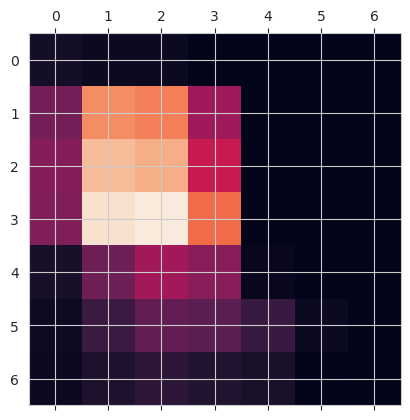

In [6]:
img_size = (224, 224)
last_conv_layer_name = "conv5_block16_concat"
model_grad.layers[-1].activation = None

img_path = "Data Kaggle/images_001/images/00000013_025.png"

img_array = get_img_array(img_path, size=img_size)
img_array = np.expand_dims(img_array, axis=0) 
preds = model_grad.predict(img_array)
preds_prob = model_grad_prob.predict(img_array)

print("Predicted:", preds)
print("Prob:", preds_prob)

heatmap = make_gradcam_heatmap(img_array, model_grad, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

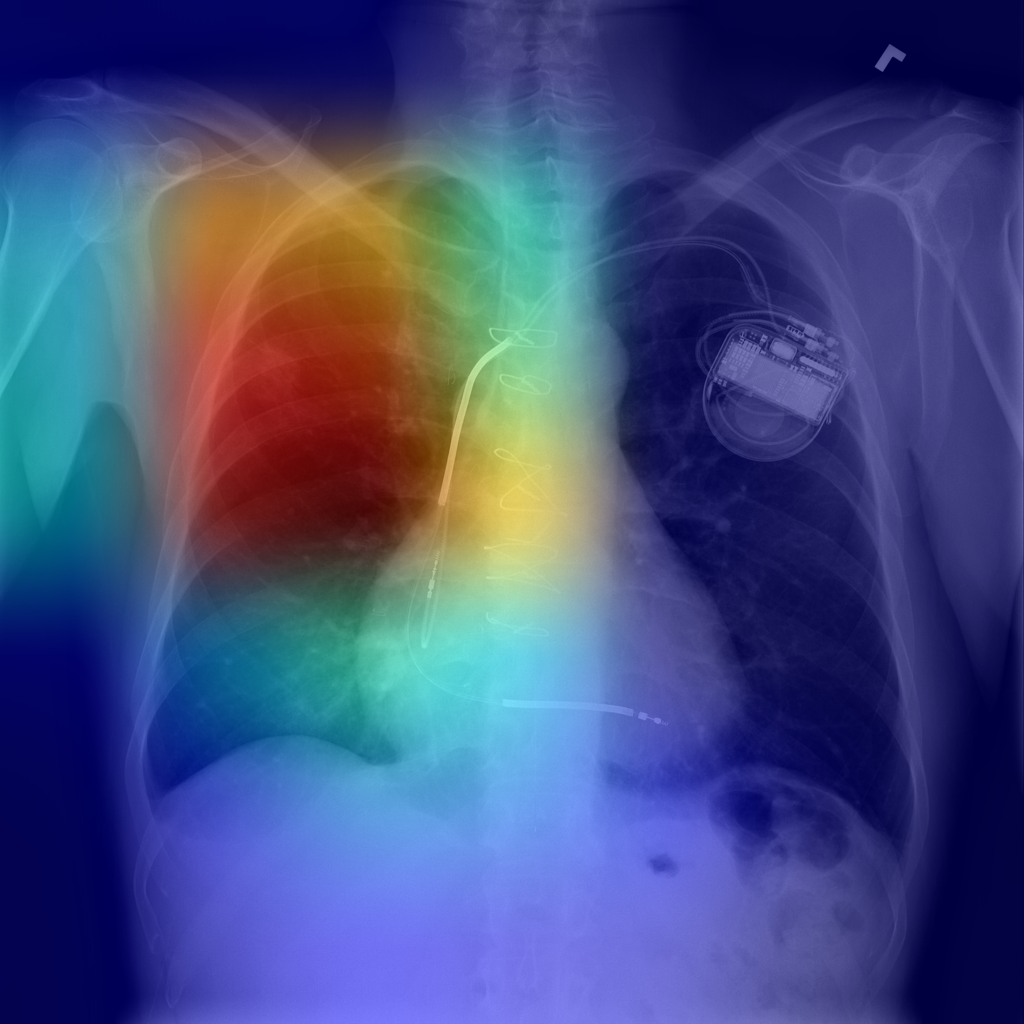

In [7]:
display_gradcam(img_path, heatmap, 1)